<a href="https://colab.research.google.com/github/yexf308/MachineLearning/blob/main/Module3/Optimization_and_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pylab inline 
import pandas as pd
from scipy import linalg
from itertools import combinations
import scipy
import torch

Populating the interactive namespace from numpy and matplotlib


$\def\m#1{\mathbf{#1}}$
$\def\mm#1{\boldsymbol{#1}}$
$\def\mb#1{\mathbb{#1}}$
$\def\c#1{\mathcal{#1}}$
$\def\mr#1{\mathrm{#1}}$
$\newenvironment{rmat}{\left[\begin{array}{rrrrrrrrrrrrr}}{\end{array}\right]}$
$\newcommand\brm{\begin{rmat}}$
$\newcommand\erm{\end{rmat}}$
$\newenvironment{cmat}{\left[\begin{array}{ccccccccc}}{\end{array}\right]}$
$\newcommand\bcm{\begin{cmat}}$
$\newcommand\ecm{\end{cmat}}$


This notebook is based on chapter 12 in Dive into deep learning. 

In deep learning, most objective functions are complicated and do not have analytical solutions. Instead, we must use numerical optimization algorithms. There are many challenges in deep learning optimization.

- **Local Minima**: For example, given the function
$$f(x) = x \cdot \text{cos}(\pi x) \text{ for } -1.0 \leq x \leq 2.0,$$
we can approximate the local minimum and global minimum of this function.

 The objective function of deep learning models usually has many local optima.
When the numerical solution of an optimization problem is near the local optimum, the numerical solution obtained by the final iteration may only minimize the objective function *locally*, rather than *globally*, as the gradient of the objective function's solutions approaches or becomes zero.
Only some degree of noise might knock the parameter out of the local minimum. In fact, this is one of the beneficial properties of
minibatch stochastic gradient descent where the natural variation of gradients over minibatches is able to dislodge the parameters from local minima.



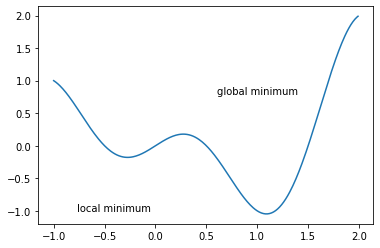

In [ ]:
def f(x):
    return x * torch.cos(np.pi * x)

x = torch.arange(-1.0, 2.0, 0.01)
plt.plot(x, f(x))
plt.annotate('local minimum', (-0.3, -0.25), (-0.77, -1.0))
plt.annotate('global minimum', (1.1, -0.95), (0.6, 0.8))
plt.show()

### Saddle Points

Besides local minima, saddle points are another reason for gradients to vanish. A *saddle point* is any location where all gradients of a function vanish but which is neither a global nor a local minimum.

Saddle points in higher dimensions are even more insidious, as the example below shows. Consider the function $f(x, y) = x^2 - y^2$. It has its saddle point at $(0, 0)$. This is a maximum with respect to $y$ and a minimum with respect to $x$.


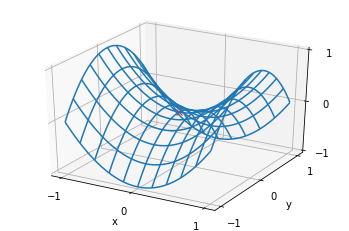

In [ ]:
x, y = torch.meshgrid(
    torch.linspace(-1.0, 1.0, 101), torch.linspace(-1.0, 1.0, 101))
z = x**2 - y**2

ax = plt.figure().add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, z, **{'rstride': 10, 'cstride': 10})
ax.plot([0], [0], [0], 'rx')
ticks = [-1, 0, 1]
plt.xticks(ticks)
plt.yticks(ticks)
ax.set_zticks(ticks)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

We assume that the input of a function is a $k$-dimensional vector and its
output is a scalar, so its Hessian matrix will have $k$ eigenvalues.
The solution of the
function could be a local minimum, a local maximum, or a saddle point at a
position where the function gradient is zero:

* When the eigenvalues of the function's Hessian matrix at the zero-gradient position are all positive, we have a local minimum for the function.
* When the eigenvalues of the function's Hessian matrix at the zero-gradient position are all negative, we have a local maximum for the function.
* When the eigenvalues of the function's Hessian matrix at the zero-gradient position are negative and positive, we have a saddle point for the function.


For high-dimensional problems the likelihood that at least *some* of the eigenvalues are negative is quite high. This makes saddle points more likely than local minima.

### Vanishing Gradients

Probably the most insidious problem to encounter is the vanishing gradient.
Recall our commonly-used activation functions and their derivatives in :numref:`subsec_activation-functions`.
For instance, assume that we want to minimize the function $f(x) = \tanh(x)$ and we happen to get started at $x = 4$. As we can see, the gradient of $f$ is close to nil.
More specifically, $f'(x) = 1 - \tanh^2(x)$ and thus $f'(4) = 0.0013$.
Consequently, optimization will get stuck for a long time before we make progress. This turns out to be one of the reasons that training deep learning models was quite tricky prior to the introduction of the ReLU activation function.

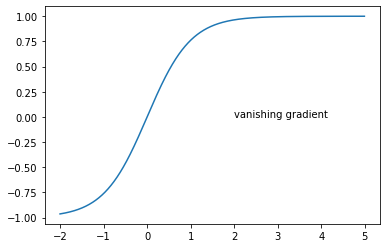

In [ ]:
x = torch.arange(-2.0, 5.0, 0.01)
plt.plot(x, torch.tanh(x))
plt.annotate('vanishing gradient', (4, 1), (2, 0.0))
plt.show()

# 1. Stochastic Gradient Descent 
We have covered enough in this course. 

$$
\begin{aligned}
    \eta_t & = \eta_i \text{ if } t_i \leq t \leq t_{i+1}  && \text{piecewise constant} \\
    \eta_t & = \eta_0 \cdot (\beta t + 1)^{-\alpha} && \text{polynomial decay}
\end{aligned}
$$

- In the first *piecewise constant* scenario we decrease the learning rate, e.g., whenever progress in optimization stalls. This is a common strategy for training deep networks. 

- For *polynomial decay* with $\alpha = 0.5$, in the case of convex optimization there are a number of proofs that show that this rate is well behaved.


# 2. Minibatch Stochastic Gradient Descent
- Gradient descent is not particularly *data efficient* whenever data is very similar.
- Stochastic gradient descent is not particularly *computationally efficient* since CPUs and GPUs cannot exploit the full power of vectorization.

Minibatch SGD can fully utilize the power of vectorization. 
In each epoch, randomly sample mini-batch $\mathcal{B}_t\subset \{1,\dots, N\}$ of fixed size $|\mathcal{B}_t|$.

Evaluate and sum up and average gradient of sample loss functions: 
$$ \mathbf{w}_{t+1}=\mathbf{w}_t-\frac{\eta_t}{|\mathcal{B}_t|} \sum_{i\in \mathcal{B}_t}\nabla f(\m{x}^{(i)}, \m{w}_t)$$ 
Minibatch SGD in fact reduces the amount of variance by averaging gradients. 

In practice we pick a minibatch $\mathcal{B}_t$ that is large enough to offer good computational efficiency while still fitting into the memory of a GPU. 

### Example: airfoil dataset

In [ ]:
!wget https://github.com/yexf308/MAT592/blob/main/data/airfoil_self_noise.dat?raw=true -O airfoil_self_noise.dat


--2022-10-17 16:53:35--  https://github.com/yexf308/MAT592/blob/main/data/airfoil_self_noise.dat?raw=true
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/yexf308/MachineLearning/blob/main/data/airfoil_self_noise.dat?raw=true [following]
--2022-10-17 16:53:35--  https://github.com/yexf308/MachineLearning/blob/main/data/airfoil_self_noise.dat?raw=true
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/yexf308/MachineLearning/raw/main/data/airfoil_self_noise.dat [following]
--2022-10-17 16:53:35--  https://github.com/yexf308/MachineLearning/raw/main/data/airfoil_self_noise.dat
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/yexf308/MachineLearning/main/data/airfoi

In [ ]:
data = np.genfromtxt('airfoil_self_noise.dat',
                         dtype=np.float32, delimiter='\t')
#data = torch.from_numpy(data)
data = torch.from_numpy((data - data.mean(axis=0)) / data.std(axis=0))
X    = data[:1500, :-1]
y    = data[:1500, -1]

Training models consists of making multiple passes over the dataset, grabbing one minibatch of examples at a time, and using them to update our model. Since this process is so fundamental to training machine learning algorithms, it is worth defining a utility function to shuffle the dataset and access it in minibatches.

In general, note that we want to use reasonably sized minibatches to take advantage of the GPU hardware, which excels at parallelizing operations. Because each example can be fed through our models in parallel and the gradient of the loss function for each example can also be taken in parallel, GPUs allow us to process hundreds of examples in scarcely more time than it might take to process just a single example.

In [ ]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [ ]:
feature_dim = X.shape[1]
w = torch.normal(0, 0.05, size=(feature_dim,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

def linreg(X, w, b):  
    return torch.matmul(X, w) + b

def squared_loss(y_hat, y):  
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2    


def sgd(params, lr, batch_size):  
    """Minibatch stochastic gradient descent."""
    with torch.no_grad():
        for w in params:
            w -= lr * w.grad / batch_size
            w.grad.zero_()
     


In [ ]:
lr = 0.03
num_epochs = 20
net = linreg
loss = squared_loss
batch_size = 10

In [ ]:
print(f'epoch {0}, loss {float(loss(net(X, w, b), y).mean()):f}')

for epoch in range(num_epochs):
    for Xi, yi in data_iter(batch_size, X, y):
        l = loss(net(Xi, w, b), yi)  # Minibatch loss in `X` and `y`
        # Compute gradient on `l` with respect to [`w`, `b`]
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # Update parameters using their gradient
   
    train_l = loss(net(X, w, b), y)
    print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 0, loss 0.480330
epoch 1, loss 0.245866
epoch 2, loss 0.243453
epoch 3, loss 0.242467
epoch 4, loss 0.242490
epoch 5, loss 0.243739
epoch 6, loss 0.246098
epoch 7, loss 0.242580
epoch 8, loss 0.242105
epoch 9, loss 0.242182
epoch 10, loss 0.242330
epoch 11, loss 0.242706
epoch 12, loss 0.242630
epoch 13, loss 0.243061
epoch 14, loss 0.242333
epoch 15, loss 0.242810
epoch 16, loss 0.242134
epoch 17, loss 0.243973
epoch 18, loss 0.245043
epoch 19, loss 0.245072
epoch 20, loss 0.242290


In [ ]:
num_epochs =2
w = torch.normal(0, 0.1, size=(feature_dim,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
N = int(X.shape[0]/batch_size)*num_epochs +1

loss_store = [loss(net(X, w, b), y).mean().detach().numpy()]
for epoch in range(num_epochs):
    for Xi, yi in data_iter(batch_size, X, y):
        l = loss(net(Xi, w, b), yi)  # Minibatch loss in `X` and `y`
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # Update parameters using their gradient
        loss_store.append(loss(net(X, w, b), y).mean().detach().numpy())
        
loss_store = np.array(loss_store)


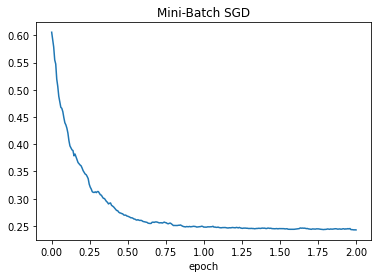

In [ ]:
epoch_list = np.linspace(0, num_epochs, N)
ax = plt.gca()
ax.plot(epoch_list, loss_store)
ax.set_xlabel('epoch')
ax.set_title('Mini-Batch SGD')
plt.show()


# 3. Momentum

The method is described as follows.
$$
\begin{aligned}
\mathbf{v}_t &\leftarrow \beta \mathbf{v}_{t-1} + \mathbf{g}_{t, t-1}, \\
\mathbf{x}_t &\leftarrow \mathbf{x}_{t-1} - \eta_t \mathbf{v}_t.
\end{aligned}
$$

Note that for $\beta = 0$ we recover regular gradient descent. $\mathbf{v}$ is the momentum. 

Equivalently, with the recursive argument

$$\begin{aligned}
\mathbf{v}_t = \beta^2 \mathbf{v}_{t-2} + \beta \mathbf{g}_{t-1, t-2} + \mathbf{g}_{t, t-1}
= \ldots, = \sum_{\tau = 0}^{t-1} \beta^{\tau} \mathbf{g}_{t-\tau, t-\tau-1}.
\end{aligned}$$
where 
large $\beta$ amounts to a long-range average, whereas small $\beta$ amounts to only a slight correction relative to a gradient method. This accelerates convergence significantly.

In the limit the terms add up to $\sum_{\tau=0}^\infty \beta^\tau = \frac{1}{1-\beta}$. In other words, rather than taking a step of size $\eta$ in gradient descent or stochastic gradient descent we take a step of size $\frac{\eta}{1-\beta}$ while at the same time, dealing with a potentially much better behaved descent direction. 


More theoretical analysis, please see [here](https://distill.pub/2017/momentum/). 


### Summary

* Momentum replaces gradients with a leaky average over past gradients. This accelerates convergence significantly.
* It is desirable for both noise-free gradient descent and (noisy) stochastic gradient descent.
* Momentum prevents stalling of the optimization process that is much more likely to occur for stochastic gradient descent.
* The effective number of gradients is given by $\frac{1}{1-\beta}$ due to exponentiated downweighting of past data.
* In the case of convex quadratic problems this can be analyzed explicitly in detail.
* Implementation is quite straightforward but it requires us to store an additional state vector (momentum $\mathbf{v}$).




In [ ]:
# implement from scratch
def sgd_momentum(params, states, lr, momentum,batch_size):
    for w, v in zip(params, states):
        with torch.no_grad():
            v[:] =  momentum * v + w.grad/batch_size
            w[:] -= lr * v
        w.grad.data.zero_()

In [ ]:
lr = 0.005
momentum = 0.9
num_epochs = 2
net = linreg
loss = squared_loss
batch_size = 10

v_w = torch.zeros((feature_dim, 1))   #<--
v_b = torch.zeros(1)        #<--

w = torch.normal(0, 0.1, size=(feature_dim,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
N = int(X.shape[0]/batch_size)*num_epochs +1

loss_store = [loss(net(X, w, b), y).mean().detach().numpy()]
for epoch in range(num_epochs):
    for Xi, yi in data_iter(batch_size, X, y):
        l = loss(net(Xi, w, b), yi).sum()  
        l.backward()
        sgd_momentum([w, b], [v_w, v_b], lr, momentum, batch_size)  #<--
        loss_store.append(loss(net(X, w, b), y).mean().detach().numpy())
        
loss_store = np.array(loss_store)

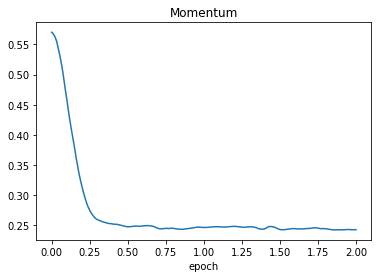

In [ ]:
epoch_list = np.linspace(0, num_epochs, N)
ax = plt.gca()
ax.plot(epoch_list, loss_store)
ax.set_xlabel('epoch')
ax.set_title('Momentum')
plt.show()

In [ ]:
# use package in pytorch
import torch.optim as optim
lr = 0.001
momentum = 0.9
num_epochs = 2
net = linreg
loss = squared_loss
batch_size = 10


w = torch.normal(0, 0.1, size=(feature_dim,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
N = int(X.shape[0]/batch_size)*num_epochs +1


optimizer = optim.SGD([w,b], lr=lr, momentum=momentum) #<--


loss_store = [loss(net(X, w, b), y).mean().detach().numpy()]
for epoch in range(num_epochs):
    for Xi, yi in data_iter(batch_size, X, y):
        optimizer.zero_grad()   #<--
        l = loss(net(Xi, w, b), yi).sum()
        l.backward()
        optimizer.step()         #<--
        loss_store.append(loss(net(X, w, b), y).mean().detach().numpy())
        
loss_store = np.array(loss_store)

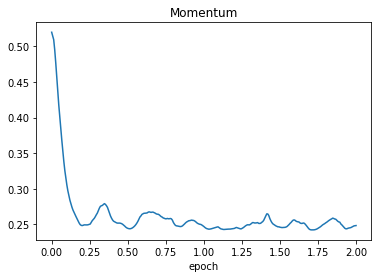

In [ ]:
epoch_list = np.linspace(0, num_epochs, N)
ax = plt.gca()
ax.plot(epoch_list, loss_store)
ax.set_xlabel('epoch')
ax.set_title('Momentum')
plt.show()

# 4.AdaGrad
If your feature is sparse, i.e., features that occur only infrequently. This is common for natural language. 

Parameters associated with infrequent features only receive meaningful updates whenever these features occur. Given a decreasing learning rate we might end up in a situation where the parameters for common features converge rather quickly to their optimal values, whereas for infrequent features we are still short of observing them sufficiently frequently before their optimal values can be determined. In other words, the learning rate either decreases too slowly for frequent features or too quickly for infrequent ones.

A possible hack to redress this issue would be to count the number of times we see a particular feature and to use this as a clock for adjusting learning rates. That is, rather than choosing a learning rate of the form $\eta = \frac{\eta_0}{\sqrt{t + c}}$ we could use $\eta_i = \frac{\eta_0}{\sqrt{s(i, t) + c}}$. Here $s(i, t)$ counts the number of nonzeros for feature $i$ that we have observed up to time $t$. However, it fails whenever we do not quite have sparsity but rather just data where the gradients are often very small and only rarely large. After all, it is unclear where one would draw the line between something that qualifies as an observed feature or not.

In AdaGrad, we use
$s(i, t+1) = s(i, t) + \left(\partial_i f(\mathbf{x})\right)^2$ as a means to adjust the learning rate. 

- We no longer need to decide just when a gradient is large enough.

- It scales automatically with the magnitude of the gradients. Coordinates that routinely correspond to large gradients are scaled down significantly, whereas others with small gradients receive a much more gentle treatment.


## The Algorithm

Let's formalize the discussion from above. We use the variable $\mathbf{s}_t$ to accumulate past gradient variance as follows.

$$\begin{aligned}
    \mathbf{g}_t & = \partial_{\mathbf{w}} l(y_t, f(\mathbf{x}_t, \mathbf{w})), \\
    \mathbf{s}_t & = \mathbf{s}_{t-1} + \mathbf{g}_t^2, \\
    \mathbf{w}_t & = \mathbf{w}_{t-1} - \frac{\eta}{\sqrt{\mathbf{s}_t + \epsilon}} \cdot \mathbf{g}_t.
\end{aligned}$$
Here the operation are applied coordinate wise.

## Summary

* Adagrad decreases the learning rate dynamically on a per-coordinate basis.
* It uses the magnitude of the gradient as a means of adjusting how quickly progress is achieved - coordinates with large gradients are compensated with a smaller learning rate.
* If the optimization problem has a rather uneven structure Adagrad can help mitigate the distortion.
* Adagrad is particularly effective for sparse features where the learning rate needs to decrease more slowly for infrequently occurring terms.
* On deep learning problems Adagrad can sometimes be too aggressive in reducing learning rates.


In [ ]:
# implement from scratch
def adagrad(params, states, lr, batch_size):
    eps = 1e-6
    for w, s in zip(params, states):
        with torch.no_grad():
            s[:] += torch.square(w.grad/batch_size)
            w[:] -= lr * (w.grad/batch_size) / torch.sqrt(s + eps)
        w.grad.data.zero_()

In [ ]:
lr = 0.1        #<--
num_epochs = 2
net = linreg
loss = squared_loss
batch_size = 10

s_w = torch.zeros((feature_dim, 1))   
s_b = torch.zeros(1)        

w = torch.normal(0, 0.1, size=(feature_dim,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
N = int(X.shape[0]/batch_size)*num_epochs +1

loss_store = [loss(net(X, w, b), y).mean().detach().numpy()]
for epoch in range(num_epochs):
    for Xi, yi in data_iter(batch_size, X, y):
        l = loss(net(Xi, w, b), yi)  
        l.sum().backward()
        adagrad([w, b], [s_w, s_b], lr,  batch_size)  #<--
        loss_store.append(loss(net(X, w, b), y).mean().detach().numpy())
        
loss_store = np.array(loss_store)

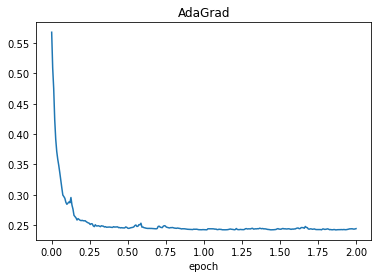

In [ ]:
epoch_list = np.linspace(0, num_epochs, N)
ax = plt.gca()
ax.plot(epoch_list, loss_store)
ax.set_xlabel('epoch')
ax.set_title('AdaGrad')
plt.show()

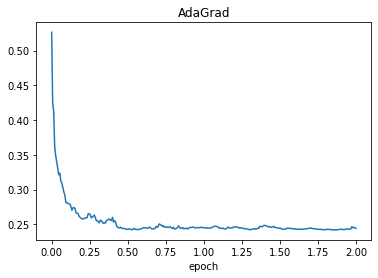

In [ ]:
# use package in pytorch 
w = torch.normal(0, 0.1, size=(feature_dim,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

optimizer = optim.Adagrad([w,b], lr=lr) #<--

loss_store = [loss(net(X, w, b), y).mean().detach().numpy()]
for epoch in range(num_epochs):
    for Xi, yi in data_iter(batch_size, X, y):
        optimizer.zero_grad()   #<--
        l = loss(net(Xi, w, b), yi).sum()
        l.backward()
        optimizer.step()         #<--
        loss_store.append(loss(net(X, w, b), y).mean().detach().numpy())
        
loss_store = np.array(loss_store)

epoch_list = np.linspace(0, num_epochs, N)
ax = plt.gca()
ax.plot(epoch_list, loss_store)
ax.set_xlabel('epoch')
ax.set_title('AdaGrad')
plt.show()

# 5.RMSProp
In AdaGrad, one can show the learning rate decreases at a predefined schedule of effectively $O(1/\sqrt{t})$. 

In [ ]:
def rmsprop(params, states, lr, gamma, batch_size):
    eps = 1e-6
    for w, s in zip(params, states):
        with torch.no_grad():
            s[:] = gamma * s + (1 - gamma) * torch.square(w.grad/batch_size)
            w[:] -= lr * (w.grad/batch_size) / torch.sqrt(s + eps)
        w.grad.data.zero_()

In [ ]:
lr = 0.01
gamma = 0.9  # <--
num_epochs = 2
net = linreg
loss = squared_loss
batch_size = 10

s_w = torch.zeros((feature_dim, 1))   
s_b = torch.zeros(1)        

w = torch.normal(0, 0.1, size=(feature_dim,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
N = int(X.shape[0]/batch_size)*num_epochs +1

loss_store = [loss(net(X, w, b), y).mean().detach().numpy()]
for epoch in range(num_epochs):
    for Xi, yi in data_iter(batch_size, X, y):
        l = loss(net(Xi, w, b), yi)  
        l.sum().backward()
        rmsprop([w, b], [s_w, s_b], lr, gamma, batch_size)  #<--
        loss_store.append(loss(net(X, w, b), y).mean().detach().numpy())
        
loss_store = np.array(loss_store)

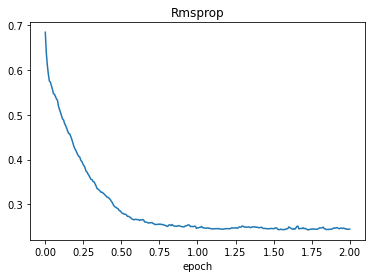

In [ ]:
epoch_list = np.linspace(0, num_epochs, N)
ax = plt.gca()
ax.plot(epoch_list, loss_store)
ax.set_xlabel('epoch')
ax.set_title('Rmsprop')
plt.show()

# 6. AdaDelta

In [ ]:
def adadelta(params, states, rho, batch_size):
    eps = 1e-6
    for w, (s, delta) in zip(params, states):
        s[:] = rho * s + (1 - rho) * np.square(w.grad)
        g = (np.sqrt(delta + eps) / np.sqrt(s + eps)) * w.grad
        w[:] -= g
        delta[:] = rho * delta + (1 - rho) * g * g

In [ ]:
s_w, s_b = np.zeros((feature_dim, 1)), np.zeros(1)
delta_w, delta_b = np.zeros((feature_dim, 1)), np.zeros(1)

